In [1]:
# this file contains code for creating mock-up stations
# elevation is calculated by linear interpolation of actual data

In [34]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans

#others
from xgboost import XGBRegressor
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import time
import xarray as xr
import sherpa
import time
from scipy.spatial import Delaunay
from scipy import interpolate
from copy import deepcopy
from matplotlib import collections as mc

# enable autoreload
%load_ext autoreload
%autoreload 2
# Variables from config file
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES, BEST_MODEL_COLUMNS
from math import pi as PI

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
test_months = [(1948, 1), (2012, 12)]

In [239]:
df_locations = pd.read_csv(f"{BASE_DIR}/SKNlocations.csv")
df_locations.rename(columns={"Lat_DD": "lat", "Lon_DD": "lon"}, inplace=True)
df_metadata = pd.read_excel(f"{BASE_DIR}/FilledDataset2012.xlsx", sheet_name="Header")
df_metadata.rename(columns={"Lat_DD": "lat", "Lon_DD": "lon", "ElevFT": "elevation"}, inplace=True)
print()

# Find the points of interest: all the points inside island convex hull

In [252]:
x_state = (-161, -154)
y_state = (18, 23)

def get_convexhull_coords(df_locations, lon_range, lat_range):
    # input: (lon, lat), output: (lon, lat)
    resolution = 500
    df_locations_island = df_locations[
        (df_locations["lat"] > lat_range[0]) &
        (df_locations["lat"] < lat_range[1]) &
        (df_locations["lon"] > lon_range[0]) &
        (df_locations["lon"] < lon_range[1])
    ]
    
    station_coords_island = df_locations_island[["lon", "lat"]].to_numpy()
    # find points that are inside the island convex hull
    hull = Delaunay(station_coords_island)
    xx, yy = np.meshgrid(np.linspace(*x_state, resolution), np.linspace(*y_state, resolution))
    candidate_coords = np.dstack((xx.flatten(), yy.flatten())).reshape(-1,2)
    idx_in = hull.find_simplex(candidate_coords)
    coords_in = candidate_coords[np.where(idx_in > -1)[0]]
    return coords_in

In [253]:
# lon_oahu = (-157.966174-0.45, -157.966174+0.45)
# lat_oahu = (21.485495-0.45, 21.485495+0.45)
island_ranges = [
    {
        "name": "kauai",
        "lat": (22.066281-0.45, 22.066281+0.45),
        "lon": (-159.526021-0.45, -159.526021+0.45)
    },
    {
        "name": "oahu",
        "lat": (21.485495-0.45, 21.485495+0.45),
        "lon": (-157.966174-0.45, -157.966174+0.45)
    },
    {
        "name": "molokai",
        "lat": (21.134806-0.15, 21.134806+0.15),
        "lon":  (-157.015431-0.35, -157.015431+0.35),
    },
    {
        "name": "lanai",
        "lat": (20.829217-0.1, 20.829217+0.1),
        "lon": (-156.926489-0.15, -156.926489+0.15),
    },
    {
        "name": "maui",
        "lat": (20.820998-0.24, 20.820998+0.24),
        "lon": (-156.312097-0.45, -156.312097+0.45)
    },
    {
        "name": "kahoolawe",
        "lat": (20.548690-0.1, 20.548690+0.1),
        "lon": (-156.608597-0.1, -156.608597+0.1)
    },
    {
        "name": "hawaii",
        "lat": (19.602708-0.7, 19.602708+0.7),
        "lon": (-155.474286-0.7, -155.474286+0.7)
    }
]

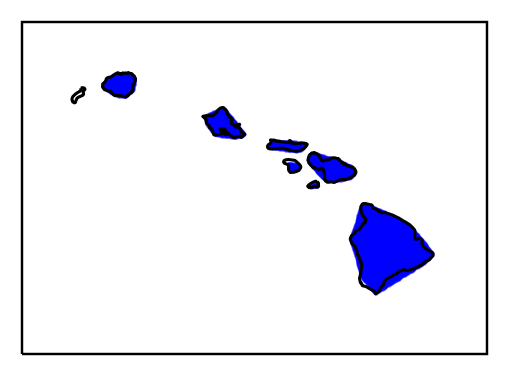

In [254]:
# test plot
xmin, xmax = -161, -154
ymin, ymax = 18, 23
# idx = 1
# xmin, xmax = island_ranges[idx]['lon']
# ymin, ymax = island_ranges[idx]['lat']

fig, ax = plt.subplots(
    1, 1, figsize=(3, 2), dpi=220,
    subplot_kw={
        'projection': ccrs.PlateCarree(),
        'xlim': (xmin, xmax),
        'ylim': (ymin, ymax)
    },
    gridspec_kw={
        "hspace": 0.1
    }
)

for island_range in island_ranges:
    test = get_convexhull_coords(
        df_locations,
        island_range['lon'], 
        island_range['lat'])
    # print(island_range['name'], len(test))
    ax.scatter(test[:, 0], test[:, 1], s=0.1, facecolor='b', edgecolor='b', alpha=0.5)

ax.coastlines(resolution='10m')

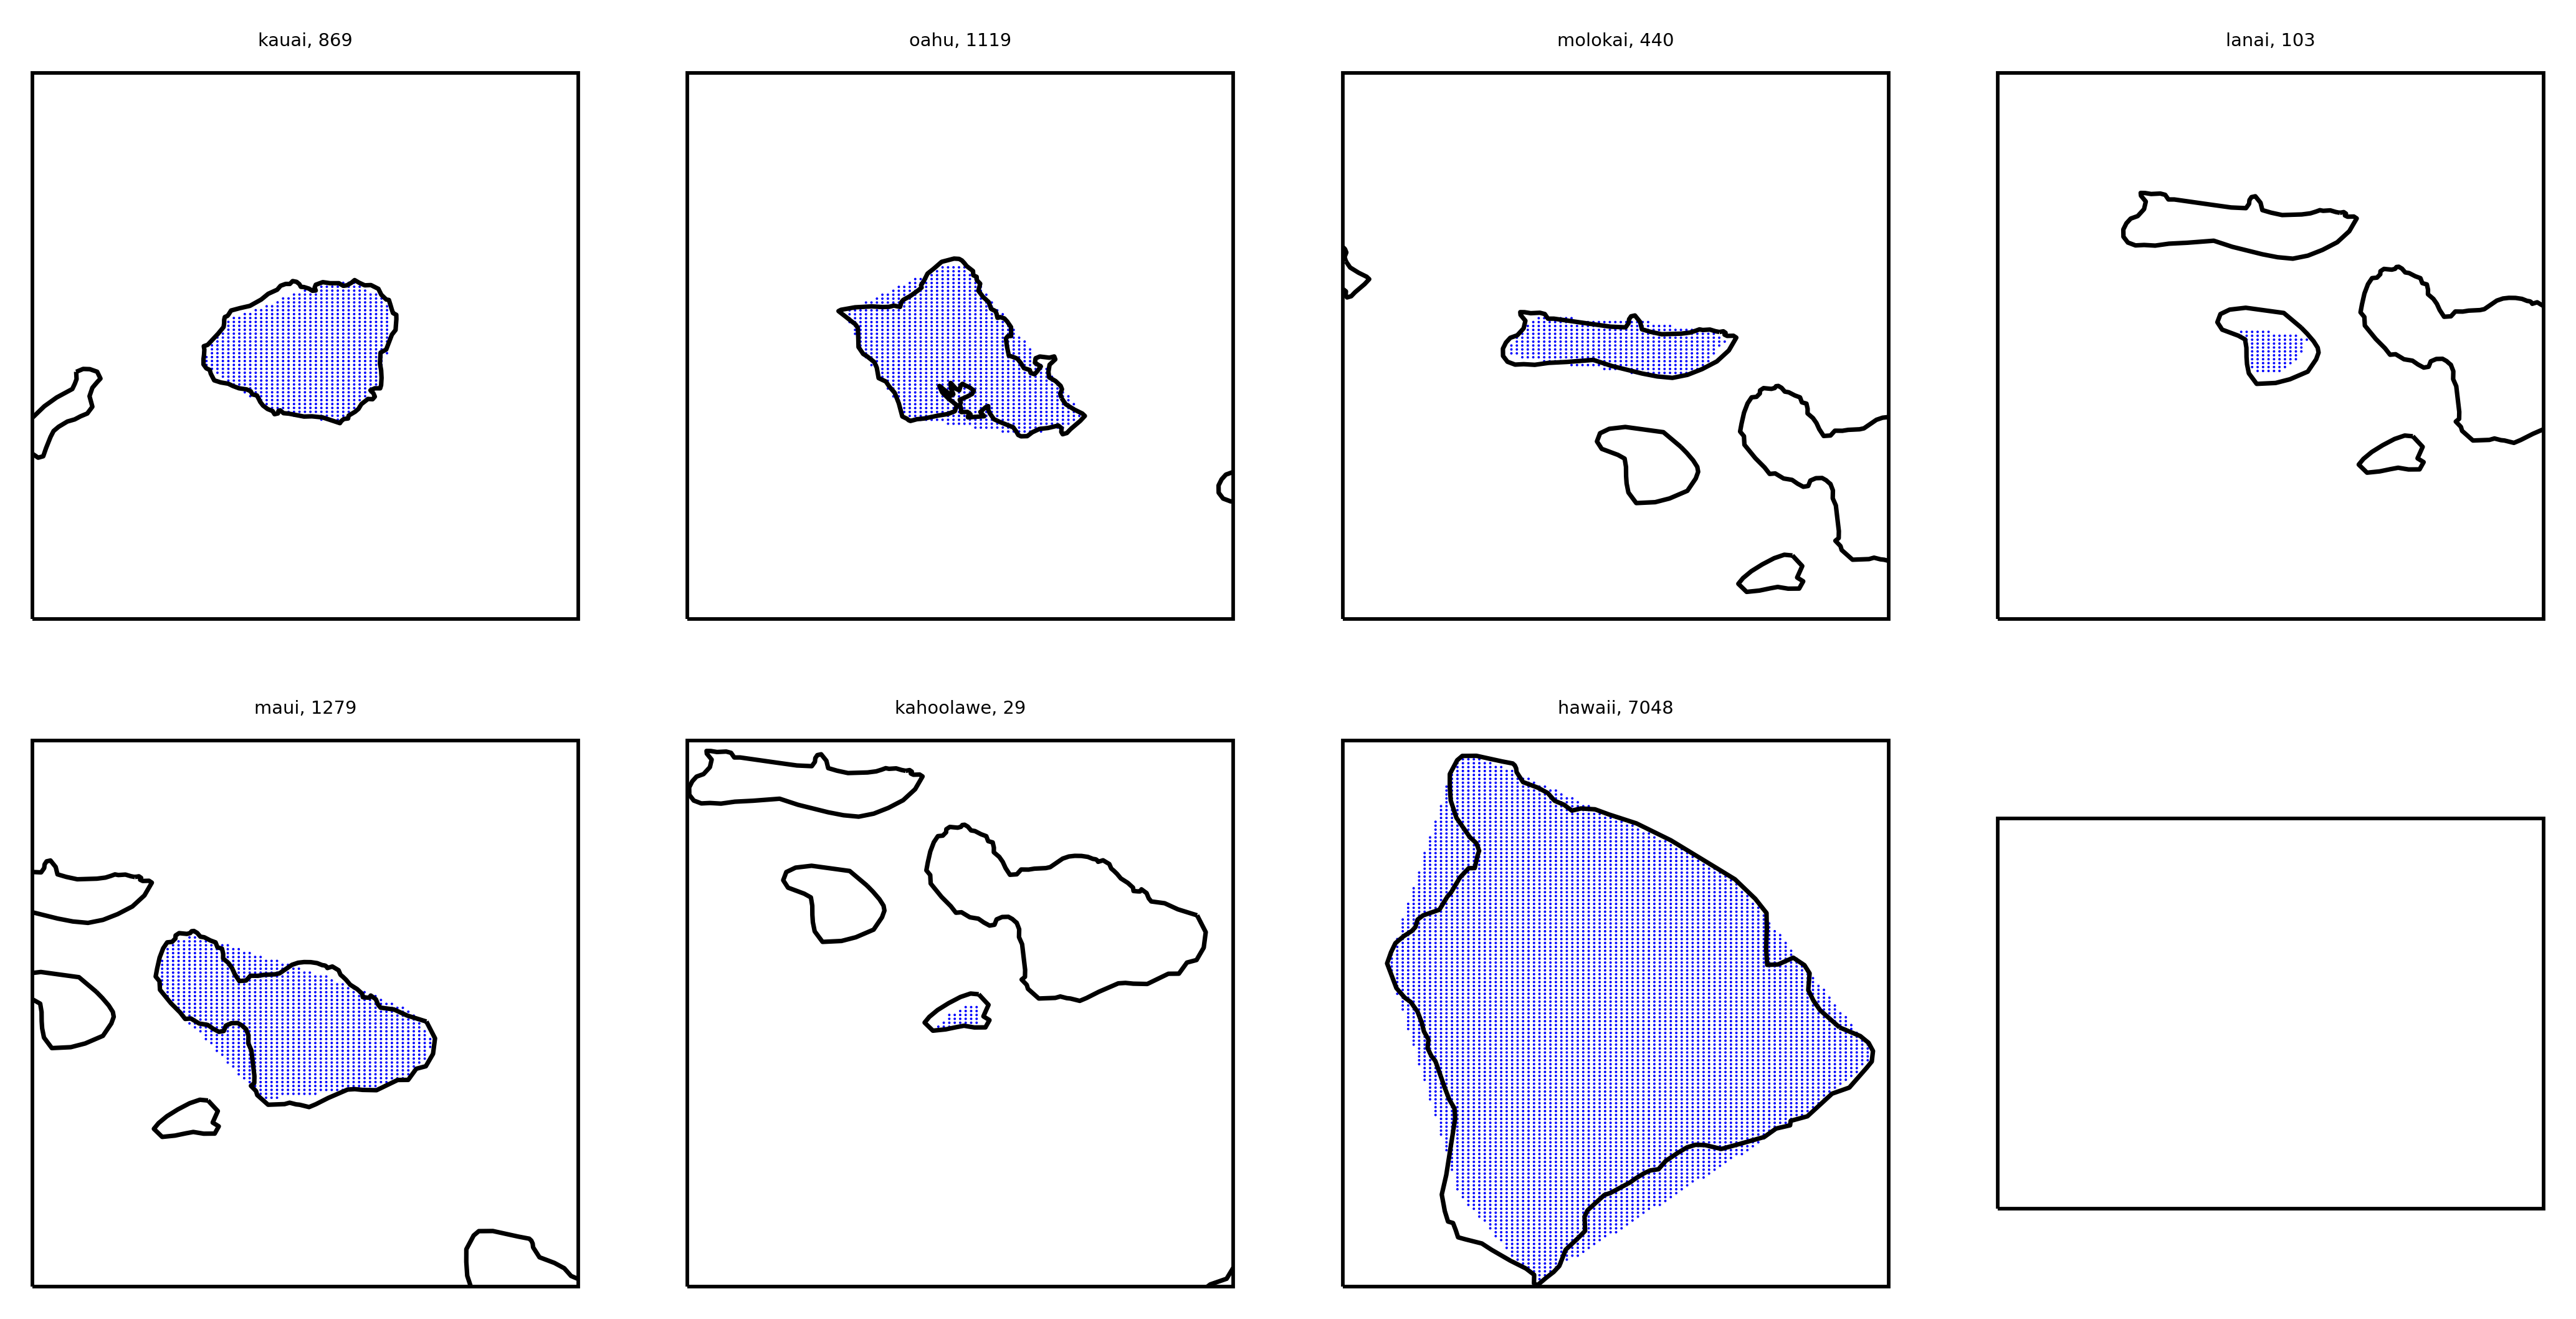

In [255]:
fig, axs = plt.subplots(
    2, 4, figsize=(10, 5), dpi=520,
    subplot_kw={
        'projection': ccrs.PlateCarree(),
        'xlim': (xmin, xmax),
        'ylim': (ymin, ymax)
    },
    gridspec_kw={
       # "hspace": 0.1
    }
)

for i, (ax, island_range) in enumerate(zip(axs.flatten(), island_ranges)):
    island_range = island_ranges[i]
    test = get_convexhull_coords(
        df_locations,
        island_range['lon'], 
        island_range['lat'])
    # print(island_range['name'], len(test))
    ax.set_title(f"{island_range['name']}, {len(test)}", fontsize=4)
    center = (
        (island_range['lon'][1] + island_range['lon'][0]) / 2, 
        (island_range['lat'][1] + island_range['lat'][0]) / 2
    )
    lim = 0.7
    ax.set_xlim((center[0] - lim, center[0] + lim))
    ax.set_ylim((center[1] - lim, center[1] + lim))
    ax.scatter(test[:, 0], test[:, 1], s=0.3, facecolor='b', edgecolor='none', alpha=1)
    ax.coastlines(resolution='10m')

# now create dataframe

In [256]:
# now create dataframe
new_coords = []
island = []
for island_range in island_ranges:
    new_coords_island = get_convexhull_coords(
        df_locations,
        island_range['lon'], 
        island_range['lat']
    )
    new_coords.extend(new_coords_island)
    island.extend(len(new_coords_island) * [island_range['name']])
df_newdata = pd.DataFrame(new_coords, columns=["lon", "lat"])
df_newdata['island'] = island

In [258]:
# height interpolation
df_elevation = df_metadata[["lon", "lat", "elevation"]]
elevation_interpolation = interpolate.griddata(
    points=np.dstack((df_elevation["lon"], df_elevation["lat"])).reshape(-1,2),
    values=df_elevation["elevation"],
    xi=np.dstack((df_newdata["lon"], df_newdata["lat"])).reshape(-1, 2),
    method="linear",
    fill_value=0
)

df_newdata['elevation'] = elevation_interpolation

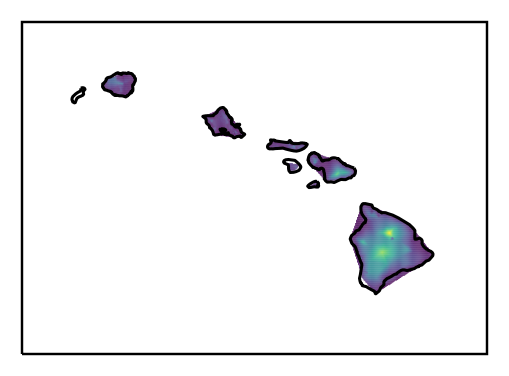

In [259]:
scaler = MinMaxScaler(feature_range=(0,1))
# test plot
xmin, xmax = -161, -154
ymin, ymax = 18, 23

fig, ax = plt.subplots(
    1, 1, figsize=(3, 2), dpi=220,
    subplot_kw={
        'projection': ccrs.PlateCarree(),
        'xlim': (xmin, xmax),
        'ylim': (ymin, ymax)
    },
    gridspec_kw={
        "hspace": 0.1
    }
)

ax.scatter(
    df_newdata['lon'],
    df_newdata['lat'],
    c=scaler.fit_transform(df_newdata['elevation'].to_numpy().reshape(-1,1)).flatten(),
    s=0.1,
    edgecolor='none'
)

ax.coastlines(resolution='10m')
print()

## find closest grid for all data

In [266]:
# implement and verify close_grid
lat = np.arange(17.5, 27.5, 2.5)
lon = np.arange(195, 207.5, 2.5)
xx, yy = np.meshgrid(lon, lat)
grids = np.dstack((xx.flatten(), yy.flatten())).reshape(-1,2)

def closest_grid(target, grids):
    # grids requirement: the longitude is in (0, 360) rather than (-180, 180)
    # target is in the form of (lon, lat)
    idx = np.linalg.norm(grids - target, axis=1).argmin()
    return grids[idx]

In [289]:
df_newdata['closest_grid'] = df_newdata.apply(lambda row: closest_grid(target=(row['lon']+360, row['lat']), grids=grids), axis=1)

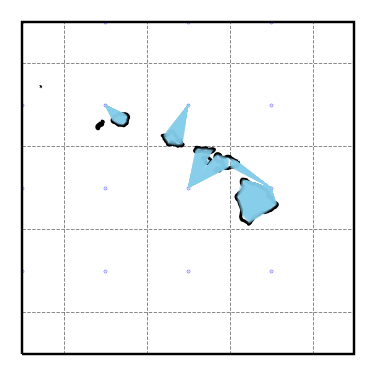

In [292]:
xmin, xmax = -162.5, -152.5
ymin, ymax = 15, 25

fig, ax = plt.subplots(
    1, 1, figsize=(3, 2), dpi=220,
    subplot_kw={
        'projection': ccrs.PlateCarree(),
        'xlim': (xmin, xmax),
        'ylim': (ymin, ymax)
    },
    gridspec_kw={
        "hspace": 0.1
    }
)

lines = []
for index, row in df_newdata.iterrows():
    closest = row['closest_grid']
    target = (row['lon'], row['lat'])
    lines.append([(closest[0]-360, closest[1]), (target[0], target[1])])
# lc = mc.LineCollection(lines, colors="skyblue", linewidth=0.1, alpha=0.3)
lc = mc.LineCollection(lines, colors=colors, linewidth=0.1, alpha=0.3)
ax.scatter(grids[:, 0], grids[:, 1], s=0.05, facecolor='b', edgecolor='b', alpha=0.5)

plt.vlines(x=np.arange(xmin, xmax+1, 2.5) - 1.25, ymin=ymin, ymax=ymax, color="k", linewidth=0.3, linestyle="--", alpha=0.5)
plt.hlines(y=np.arange(ymin, ymax+1, 2.5) - 1.25 , xmin=xmin, xmax=xmax, color="k", linewidth=0.3, linestyle="--", alpha=0.5)
ax.add_collection(lc)
ax.coastlines(resolution='10m')

In [ ]:
unique_rows = np.unique(np.hstack(df_data_w_coord["closest_grid"].to_numpy().tolist()).reshape(-1, 2), axis=0)

In [ ]:
# load netcdf file
# ds = xr.open_dataset(f"{base_dir}/air.2m.mon.mean.regridded.nc")
unique_rows = np.unique(np.hstack(df_data_w_coord["closest_grid"].to_numpy().tolist()).reshape(-1, 2), axis=0)
unique_lat = np.unique(unique_rows[:, 0])
unique_lon = np.unique(unique_rows[:, 1])

ds_air2m = xr.open_dataset(f"{BASE_DIR}/air.2m.mon.mean.regridded.nc").loc[dict(lat=unique_lat, lon=unique_lon)]
ds_air1000_500 = xr.open_dataset(f"{BASE_DIR}/air.1000-500.mon.mean.nc").loc[dict(lat=unique_lat, lon=unique_lon)]
ds_hgt500 = xr.open_dataset(f"{BASE_DIR}/hgt500.mon.mean.nc").loc[dict(lat=unique_lat, lon=unique_lon)]
ds_hgt1000 = xr.open_dataset(f"{BASE_DIR}/hgt1000.mon.mean.nc").loc[dict(lat=unique_lat, lon=unique_lon)]
ds_omega500 = xr.open_dataset(f"{BASE_DIR}/omega500.mon.mean.nc").loc[dict(lat=unique_lat, lon=unique_lon)]
ds_pottemp_1000_500 = xr.open_dataset(f"{BASE_DIR}/pottmp.1000-500.mon.mean.nc").loc[dict(lat=unique_lat, lon=unique_lon)]
ds_pottemp_1000_850 = xr.open_dataset(f"{BASE_DIR}/pottmp.1000-850.mon.mean.nc").loc[dict(lat=unique_lat, lon=unique_lon)]
ds_pwtr = xr.open_dataset(f"{BASE_DIR}/pwtr.mon.mean.nc").loc[dict(lat=unique_lat, lon=unique_lon)]
ds_u700 = xr.open_dataset(f"{BASE_DIR}/shum_x_uwnd.700.mon.mean.nc").loc[dict(lat=unique_lat, lon=unique_lon)]
ds_u925 = xr.open_dataset(f"{BASE_DIR}/shum_x_uwnd.925.mon.mean.nc").loc[dict(lat=unique_lat, lon=unique_lon)]
ds_v700 = xr.open_dataset(f"{BASE_DIR}/shum_x_vwnd.700.mon.mean.nc").loc[dict(lat=unique_lat, lon=unique_lon)]
ds_v950 = xr.open_dataset(f"{BASE_DIR}/shum_x_vwnd.925.mon.mean.nc").loc[dict(lat=unique_lat, lon=unique_lon)]
ds_shum700 = xr.open_dataset(f"{BASE_DIR}/shum700.mon.mean.nc").loc[dict(lat=unique_lat, lon=unique_lon)]
ds_shum925 = xr.open_dataset(f"{BASE_DIR}/shum925.mon.mean.nc").loc[dict(lat=unique_lat, lon=unique_lon)]
ds_skt = xr.open_dataset(f"{BASE_DIR}/skt.mon.mean.regridded.nc").loc[dict(lat=unique_lat, lon=unique_lon)]
ds_slp = xr.open_dataset(f"{BASE_DIR}/slp.mon.mean.nc").loc[dict(lat=unique_lat, lon=unique_lon)]

datasets = [ # list of tuples. (dataset object, attribute string in ds)
    (ds_air2m, "air"),
    (ds_air1000_500, "air"),
    (ds_hgt500, "hgt"),
    (ds_hgt1000, "hgt"),
    (ds_omega500, "omega"),
    (ds_pottemp_1000_500, "pottmp"),
    (ds_pottemp_1000_850, "pottmp"),
    (ds_pwtr, "pr_wtr"),
    (ds_u700, "shum"),
    (ds_u925, "shum"),
    (ds_v700, "shum"),
    (ds_v950, "shum"),
    (ds_shum700, "shum"),
    (ds_shum925, "shum"),
    (ds_skt, "skt"),
    (ds_slp, "slp")
]
# combine all the cdf data